<a href="https://colab.research.google.com/github/zwellman99/Rideshare-Driver-Model-Recommendation/blob/main/UberDemand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing data

In [ ]:
!pip install simple-colors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import opendatasets as od
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from datetime import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from simple_colors import *

In [ ]:
od.download("https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma")
os.chdir('/content/uber-and-lyft-dataset-boston-ma')
df = pd.read_csv("rideshare_kaggle.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: blakeandersonw
Your Kaggle Key: ··········


100%|██████████| 44.5M/44.5M [00:00<00:00, 54.6MB/s]


In [ ]:
od.download("https://www.kaggle.com/datasets/yasserh/uber-fares-dataset")
os.chdir('/content/uber-and-lyft-dataset-boston-ma/uber-fares-dataset')
df = pd.read_csv("uber.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: blakeandersonw
Your Kaggle Key: ··········


100%|██████████| 7.04M/7.04M [00:00<00:00, 57.1MB/s]

**username:** blakeandersonw

**key:** 5c7b7542c5ad7af0d6015b98bfa868b4

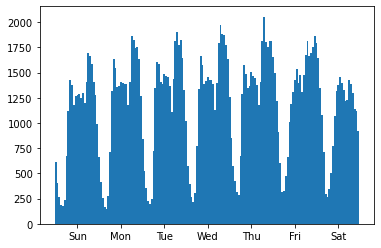

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
# Group the data by day of the week and hour of the day, and count the number of rides
weekly_demand = df.groupby([df['pickup_datetime'].dt.dayofweek, df['pickup_datetime'].dt.hour]).size().unstack()

# Reshape the weekly demand data into a one-dimensional array
weekly_demand_reshaped = weekly_demand.values.reshape(-1)

# Plot the average hourly demand for each day of the week as a bar graph
fig, ax = plt.subplots()
ax.bar(x=range(168), height=weekly_demand_reshaped, width=1)
ax.set_xticks([12 + i*24 for i in range(7)])
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

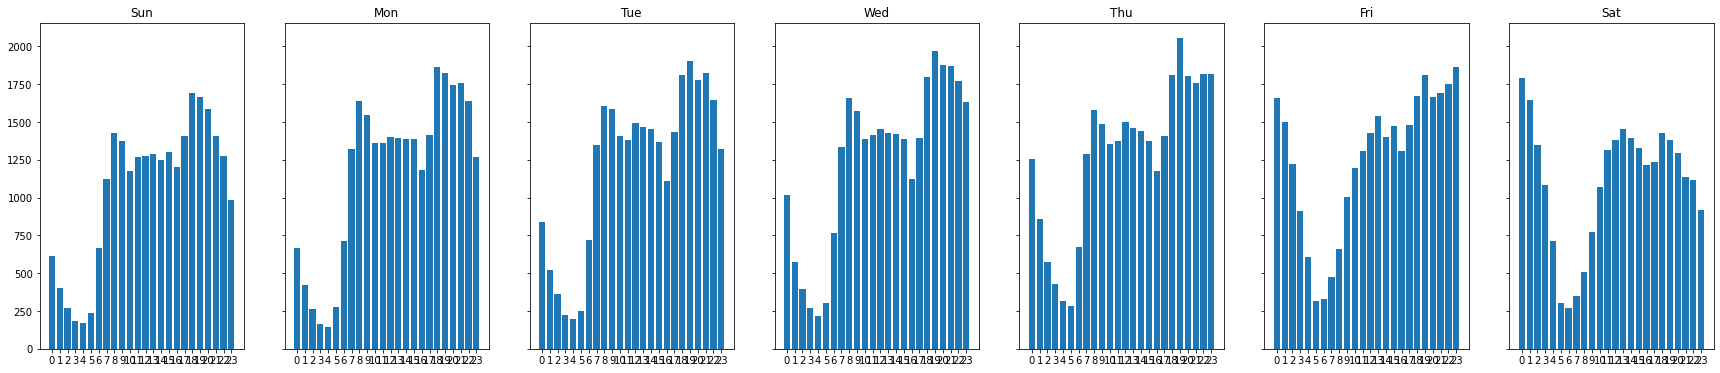

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(30, 6), sharey=True)
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

for i, day in enumerate(days):
    axs[i].bar(range(24), weekly_demand.loc[i], width=0.8)
    axs[i].set_xticks(range(24))
    axs[i].set_xticklabels(range(24))
    axs[i].set_title(day)

plt.show()


In [ ]:
def calc_demand(num_rides, num_drivers):
  return(num_rides/num_drivers)

## Predicting Price

###Examining location distribution... all in New York

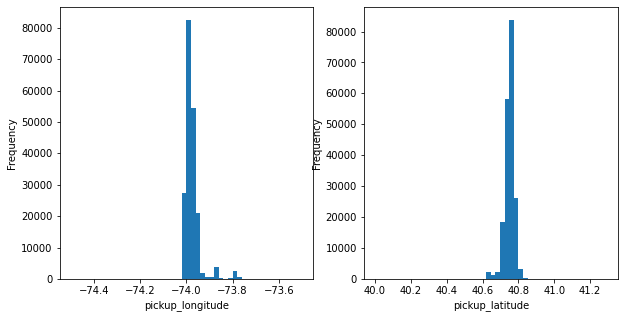

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

filtered_df = df[(df['pickup_longitude'] >= -74.5) & (df['pickup_longitude'] <= -73.5) & (df['pickup_latitude'] >= 40) & (df['pickup_latitude'] <= 42)]

# Plot distribution of pickup_longitude
axs[0].hist(filtered_df['pickup_longitude'], bins=50)
axs[0].set_xlabel('pickup_longitude')
axs[0].set_ylabel('Frequency')

# Plot distribution of pickup_latitude
axs[1].hist(filtered_df['pickup_latitude'], bins=50)
axs[1].set_xlabel('pickup_latitude')
axs[1].set_ylabel('Frequency')

# Display the plot
plt.show()

###Editing dataset for analysis

Calculating distance (as a hawk flies)

In [ ]:
from math import radians, sin, cos, sqrt, asin

def haversine_distance(row):
    """
    Calculate the great circle distance between two points
    on the Earth (specified in decimal degrees)
    """
    # unpack the values from the row
    lat1, lon1, lat2, lon2 = row[['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude']]
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3959 for miles
    return c * r

# Apply the function to the DataFrame and assign the result to a new column
df['distance'] = df.apply(haversine_distance, axis=1)

Converting datetime to EST, then adding hour, day of week, and month columns.

In [ ]:
import pytz
from datetime import datetime

# Convert pickup_datetime column to EST timezone
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert(pytz.timezone('US/Eastern'))
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,day,month
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 15:52:06-04:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,15,3,5
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 16:04:56-04:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,16,4,7
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 17:45:00-04:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,17,0,8
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 04:22:21-04:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,4,4,6
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 13:47:00-04:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,13,3,8


Replacing null values.

In [ ]:
# Replace null values with median integer for passenger_count, hour, day, and month
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].median())
df['hour'] = df['hour'].fillna(df['hour'].median())
df['day'] = df['day'].fillna(df['day'].median())
df['month'] = df['month'].fillna(df['month'].median())

# Replace null values with the mean for distance
df['distance'] = df['distance'].fillna(df['distance'].mean())

###Price modeling.


Linear Regression R-squared: 0.0012
Decision Tree R-squared: 0.3656
Random Forest R-squared: 0.6440
[15:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost R-squared: 0.6814


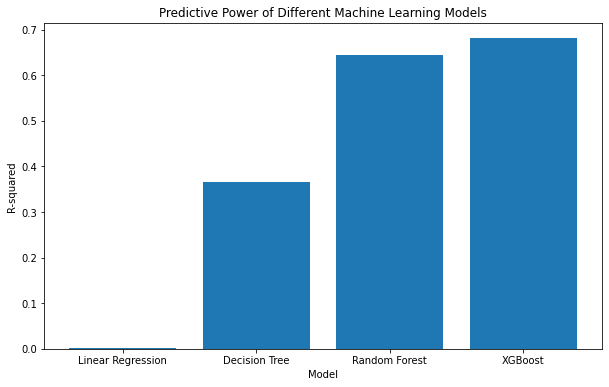

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Separate the features and target variable
X = df[['passenger_count', 'hour', 'day', 'month', 'distance']]
y = df['fare_amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the models
models = {'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(random_state=42),
          'XGBoost': XGBRegressor(random_state=42)}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} R-squared: {r2:.4f}")

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(models.keys(), [r2_score(y_test, model.predict(X_test)) for model in models.values()])
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
ax.set_title('Predictive Power of Different Machine Learning Models')
plt.show()

In [ ]:
import xgboost as xgb

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Save the XGBoost model to disk
xgb_model.save_model('xgb_model.bin')

# Create a function that uses the saved model to predict fare amount
def predict_fare_amount(passenger_count, hour, day, month, distance):
    # Load the trained model from disk
    model = xgb.Booster()
    model.load_model('xgb_model.bin')

    # Prepare the input data as a Pandas DataFrame
    data = {'passenger_count': [passenger_count],
            'hour': [hour],
            'day': [day],
            'month': [month],
            'distance': [distance]}
    df = pd.DataFrame(data)

    # Use the trained model to make a prediction
    prediction = model.predict(xgb.DMatrix(df))[0]

    # Return the predicted fare amount
    return prediction


[15:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Use the trained model to predict fare amount for the test set
y_pred = xgb_model.predict(X_test)

# Compare the predictions with the actual values
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

        Actual  Predicted
119737     5.5   5.422705
72272     45.0  12.335295
158154     5.3   8.611411
65426     32.3  23.104506
30074      4.1   5.314526
